# Stationary state solutions

TODO:

- Plot solutions side by side with I0 = 1, I0 = 10, on same scale, for I0 effect 

- Set integer levels of k^{*} in the contour plot 

- Choose 3 regimes of beta1, beta2 value pairs

- Such that k^{*} = .25, .5, .75 * N

- Add these points to the contour plot 
```python
    plt.plot(point_a[0], point_regime_low[1], 'ro')
    plt.plot(point_b[0], point_regime_mid[1], 'ro')
    plt.plot(point_b[0], point_regime_high[1], 'ro')
```


In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.integrate import solve_ivp
import pickle
import sys

In [2]:
sys.path.append("../src/")
from solve_kolmogorov import *

In [24]:
# setup
g_type = "complete"

# TODO: increase these values
N = 100
g = CompleteHypergraph(N)

I0 = 1

time_max = 20

beta1 = 2 / N       # pairwise infection rate
beta2 = 4 / (N**2)  # hyperedge contagion rate
mu    = 1           # recovery rate

print(f"Setup: \n")
print(f"\tH = Complete Hypergraph, N = {N}, I0 = {I0}\n")
print(f"\tbeta1 = {beta1}, beta2 = {beta2}, mu = {mu}\n")

Setup: 

	H = Complete Hypergraph, N = 100, I0 = 1

	beta1 = 0.02, beta2 = 0.0004, mu = 1



## Pairs of beta1, beta2 values

In [25]:
# define a mesh (beta1, beta2) values
# scale it later
beta1_steps, beta2_steps = 10, 10
beta1_max, beta2_max = 3, 7
beta1_max / N, beta2_max / (N**2)

(0.03, 0.0007)

In [26]:
# shift for eps first, so eps is not too small
eps = 1e-1 
beta1_vec = np.linspace(eps, beta1_max, beta1_steps)
beta2_vec = np.linspace(eps, beta2_max, beta2_steps)
print(f"beta1_vec = {beta1_vec}\n")
print(f"beta2_vec = {beta2_vec}")

beta1_vec = [0.1        0.42222222 0.74444444 1.06666667 1.38888889 1.71111111
 2.03333333 2.35555556 2.67777778 3.        ]

beta2_vec = [0.1        0.86666667 1.63333333 2.4        3.16666667 3.93333333
 4.7        5.46666667 6.23333333 7.        ]


In [27]:
# scale it
beta1_vec = beta1_vec / N
beta2_vec = beta2_vec / (N**2)

print(f"beta1_vec = {beta1_vec}\n")
print(f"beta2_vec = {beta2_vec}")

beta1_vec = [0.001      0.00422222 0.00744444 0.01066667 0.01388889 0.01711111
 0.02033333 0.02355556 0.02677778 0.03      ]

beta2_vec = [1.00000000e-05 8.66666667e-05 1.63333333e-04 2.40000000e-04
 3.16666667e-04 3.93333333e-04 4.70000000e-04 5.46666667e-04
 6.23333333e-04 7.00000000e-04]


## Stationary / steady states $k^* = E[X(t_{max})]$

In [28]:
k_star = np.zeros((beta1_steps, beta2_steps)) # to store the values k^* = E[X(t_max)]

In [29]:
M = N + 1 # number of all states

all_states = list_all_states(g)
M, len(all_states)

(101, 101)

In [30]:
# set the initial condition
p0 = np.zeros(M)
p0[I0] = 1.0 # all other states have prob 0 at time 0
print(f"p0 = {p0[:20]} ...")

# time range and times to evaluate solution
nsteps = 101
t_span = (0.0, time_max)
t_eval = np.linspace(t_span[0], t_span[1], nsteps)

p0 = [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...


In [31]:
solve_for_betas = True
# save solutions to run it once
file_path = f"../results/KE_solutions_G={g_type}_N={N}_I0={I0}.pickle"

if solve_for_betas:
    solutions = {}
    for i, beta1 in enumerate(beta1_vec):
        for j, beta2 in enumerate(beta2_vec):
            ode_system_complete = list_all_ODEs_complete(g, beta1, beta2, mu)

            def f_ode(t, p):
                return ode_system_complete(t, p)

            sol = solve_ivp(f_ode, 
                            t_span, 
                            p0, 
                            t_eval=t_eval,
                            method="LSODA"
            )
            solutions[str((i, j))] = sol
    # save the solutions
    with open(file_path, "wb") as f:
        pickle.dump(solutions, f)
else:
    # load solutions
    with open(file_path, "rb") as f:
        solutions = pickle.load(f)

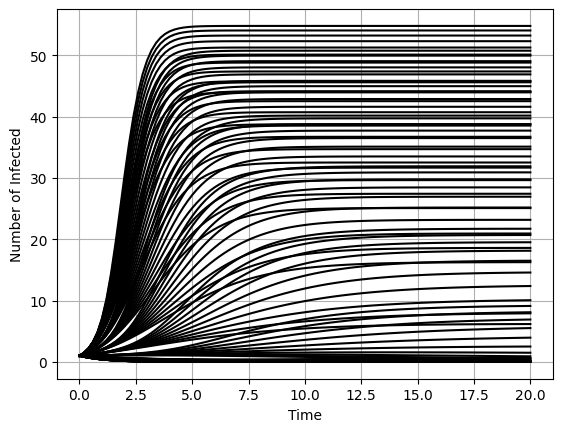

In [32]:
# plot expected values of p_{k}(t) over time t
plt.figure()
for i, beta1 in enumerate(beta1_vec):
    for j, beta2 in enumerate(beta2_vec):
        sol = solutions[str((i, j))]
        expected_values = calculate_expected_values(sol)
        
        k_star[i, j] = expected_values[-1]

        plt.plot(sol.t, expected_values, color="k")

plt.xlabel("Time")
plt.ylabel("Number of Infected")
# plt.legend() # no legend
plt.grid(True)
plt.savefig(f"../figures/solutions-kolmogorov/complete/KE_solutions_G={g_type}_N={N}_I0={I0}.pdf", 
            format="pdf", bbox_inches="tight")
plt.show()

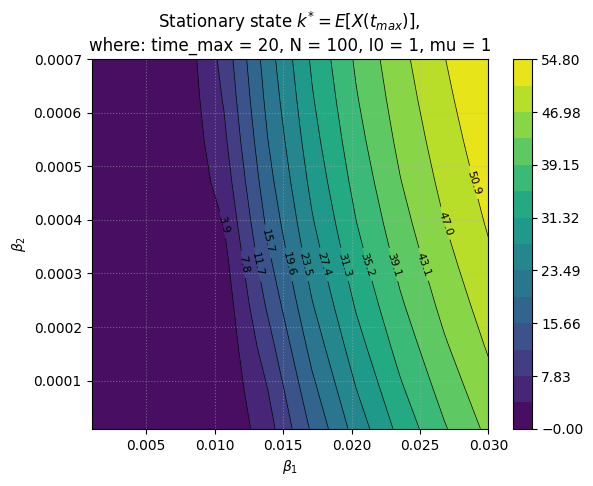

In [ ]:
B1, B2 = np.meshgrid(beta1_vec, beta2_vec)
plt.figure()
# 
levels = np.linspace(k_star.min(), k_star.max(), 15) # TODO: set levels

contourf_plot = plt.contourf(B1, B2, k_star.T, levels=levels, cmap="viridis") # use k_star.T!!
contour_plot = plt.contour(B1, B2, k_star.T, levels=contourf_plot.levels, colors="k", linewidths=0.5)

plt.clabel(contour_plot, inline=True, fontsize=8, fmt="%.1f")

cbar = plt.colorbar(contourf_plot)
cbar.set_label(r"")

plt_title = r"Stationary state $k^{*} = E[X(t_{max})]$, "
plt_title += f"\nwhere: time_max = {time_max}, N = {N}, I0 = {I0}, mu = {mu}"
plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$\beta_2$")
plt.title(plt_title)
plt.grid(True, linestyle=":", alpha=0.5)
plt.savefig(f"../figures/solutions-kolmogorov/complete/contour_KE_solutions_G={g_type}_N={N}_I0={I0}.pdf", 
            format="pdf", bbox_inches="tight")
plt.show()